In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform


In [10]:
df = pd.read_csv("data/destinations.csv", encoding="ISO-8859-1")


df_geo = df[["Latitude", "Longitude"]].dropna()

print("Total de destinos:", len(df_geo))
df_geo.head()

scaler = StandardScaler()
X_std = scaler.fit_transform(df_geo.values)

print("Dados padronizados:", X_std.shape)


Total de destinos: 209
Dados padronizados: (209, 2)


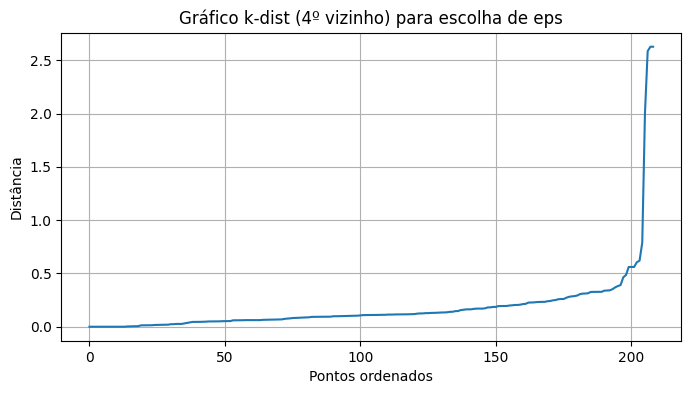

In [11]:
from sklearn.neighbors import NearestNeighbors

# Usar o 4º vizinho mais próximo (recomendado em DBSCAN)
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_std)
distances, indices = neighbors_fit.kneighbors(X_std)

# Ordenar as distâncias do 4º vizinho
distances = np.sort(distances[:, 3])

plt.figure(figsize=(8,4))
plt.plot(distances)
plt.title("Gráfico k-dist (4º vizinho) para escolha de eps")
plt.xlabel("Pontos ordenados")
plt.ylabel("Distância")
plt.grid(True)
plt.show()


In [12]:
eps_value = 0.35   # escolha após olhar o gráfico
min_samples_value = 5

db = DBSCAN(eps=eps_value, min_samples=min_samples_value)
labels = db.fit_predict(X_std)

print("Clusters encontrados:", set(labels))
print("Total de ruídos:", list(labels).count(-1))


Clusters encontrados: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(-1)}
Total de ruídos: 15


Silhouette não aplicável (só 1 cluster ou há ruídos).


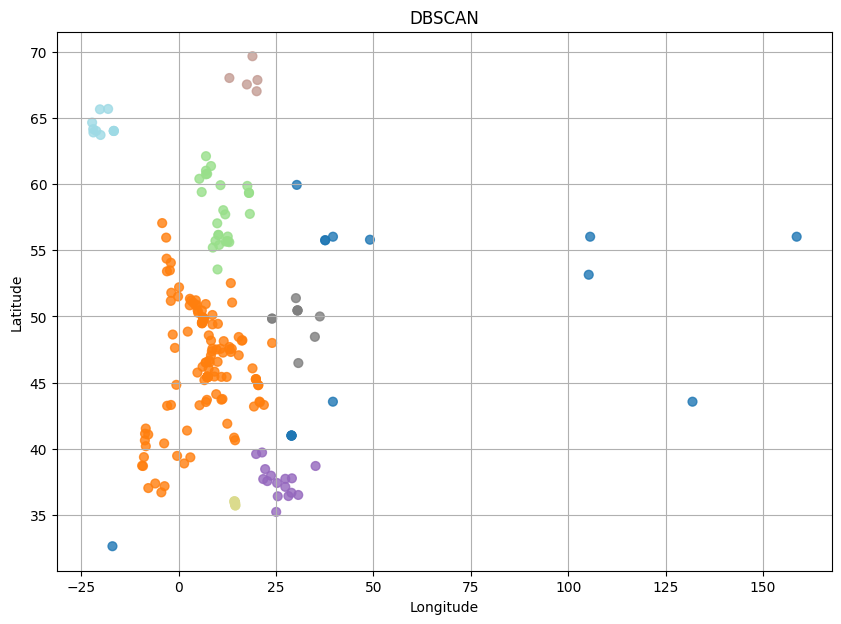

In [17]:
if len(set(labels)) > 1 and -1 not in set(labels):
    sil = silhouette_score(X_std, labels)
    print("Silhouette:", sil)
else:
    print("Silhouette não aplicável (só 1 cluster ou há ruídos).")

plt.figure(figsize=(10,7))

plt.scatter(df_geo["Longitude"], df_geo["Latitude"], 
            c=labels, cmap="tab20", s=40, alpha=0.8)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"DBSCAN")
plt.grid(True)
plt.show()

